In [96]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# plotting
import matplotlib.pyplot as plt

# saving
import joblib

In [71]:
X_train = joblib.load('data/X_train_preprocessed.pkl')
X_test = joblib.load('data/X_test_preprocessed.pkl')
y_train = joblib.load('data/y_train_preprocessed.pkl')
y_test = joblib.load('data/y_test_preprocessed.pkl')

In [72]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [73]:
knn = KNeighborsClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [102]:
param_grid = [
    {
        'metric': ['minkowski'],
        'p': [1, 2],  # hyperparametro usado apenas com a metrica minkowski
        'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
        'weights': ['uniform', 'distance']
    },
    {
        'metric': ['euclidean', 'manhattan'],
        'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
        'weights': ['uniform', 'distance']
    }
]

In [75]:
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=skf,
    scoring=scoring,
    refit='f1_macro',
    n_jobs=-1
)

In [76]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'metric': ['minkowski'],
                          'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
                          'p': [1, 2], 'weights': ['uniform', 'distance']},
                         {'metric': ['euclidean', 'manhattan'],
                          'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
                          'weights': ['uniform', 'distance']}],
             refit='f1_macro',
             scoring={'accuracy': 'accuracy',
                      'f1_macro': make_scorer(f1_score, response_method='predict', average=macro),
                      'precision_macro': make_scorer(precision_score, response_method='predict', average=macro),
                      'recall_macro': make_scorer(recall_score, response_method='predict', average=macro)})

In [83]:
results = pd.DataFrame(grid_search.cv_results_)
results = results[
    [
        'mean_fit_time', 'mean_score_time', 'param_metric', 'param_n_neighbors', 'param_p',
        'param_weights', 'mean_test_accuracy', 'mean_test_precision_macro', 'mean_test_recall_macro', 
        'mean_test_f1_macro', 'rank_test_accuracy', 'rank_test_precision_macro', 'rank_test_recall_macro', 
        'rank_test_f1_macro'
    ]
]
results = results.sort_values(by='mean_test_f1_macro', ascending=False)
pd.set_option('display.max_columns', None)
results.head(5)

,mean_fit_time,mean_score_time,param_metric,param_n_neighbors,param_p,param_weights,mean_test_accuracy,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_macro,rank_test_accuracy,rank_test_precision_macro,rank_test_recall_macro,rank_test_f1_macro
32,0.010251,0.124798,euclidean,1,NaN,uniform,0.847885,0.724178,0.725262,0.724494,55,55,1,1
2,0.008307,0.068744,minkowski,1,2.0,uniform,0.847885,0.724178,0.725262,0.724494,55,55,1,1
3,0.009508,0.071569,minkowski,1,2.0,distance,0.847885,0.724178,0.725262,0.724494,55,55,1,1
33,0.012017,0.068891,euclidean,1,NaN,distance,0.847885,0.724178,0.725262,0.724494,55,55,1,1
47,0.010870,0.078521,euclidean,20,NaN,distance,0.888470,0.920500,0.668159,0.717805,1,1,13,5


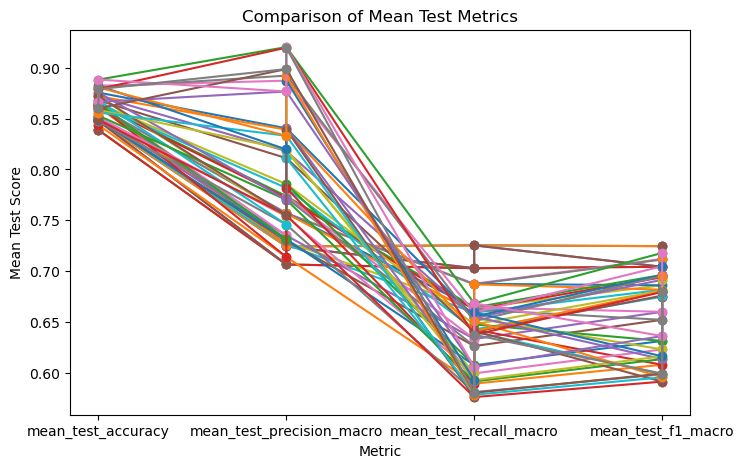

In [89]:
results_df = pd.DataFrame(grid_search.cv_results_)

# Let's pick the mean_test_* columns we want to compare
metrics = [
    "mean_test_accuracy",
    "mean_test_precision_macro",
    "mean_test_recall_macro",
    "mean_test_f1_macro"
]

#############################################
# (Optional) Filter to top models
#############################################
# For instance, select the 5 best models according to F1_macro
top_n = 5
results_top = results_df.nsmallest(top_n, "rank_test_f1_macro")

#############################################
# Melt the DataFrame to "long" format:
#############################################
# Identify any parameter columns you want in your plot label.
# E.g., 'param_n_neighbors', 'param_metric', 'param_p', 'param_weights', etc.
param_cols = ["param_n_neighbors", "param_metric", "param_weights"]
plot_df = results_df.melt(
    id_vars=param_cols,      # keep these columns "as is"
    value_vars=metrics,      # the columns we want to "unpivot"
    var_name="metric",       # new column with the metric name
    value_name="score"       # new column with the metric value
)

#############################################
# Plot each param setting (model) as its own line
#############################################
plt.figure(figsize=(8, 5))

# groupby the parameter combination so each unique combo is one line
for combo, group in plot_df.groupby(param_cols):
    # Create a label describing these parameters
    # e.g., combo = (3, "minkowski", "uniform")
    # Make a nice string:
    label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
    
    # Plot the metric vs. score
    # 'metric' will be the x-axis (categorical) and 'score' will be y-axis
    plt.plot(group["metric"], group["score"], marker='o', label=label_str)

plt.xlabel("Metric")
plt.ylabel("Mean Test Score")
plt.title(f"Comparison of Mean Test Metrics")
#plt.legend()
plt.show()

Como os modelos ficaram com recall e, consequentemente, f1-score baixo, isso indica que o modelo provavelmente está com bom desempenho para uma classe, mas não para outra. Isso pode acontecer por conta do desbalanceamento entre as classes, então podemos tentar aplicar técnicas de balanceamento.

In [ ]:
def os_smote(X, y):
    # auto faz resampling de todas as classes, menos a minoritária
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    return X_balanced, y_balanced

In [97]:
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('knn', KNeighborsClassifier())
])

In [111]:
pipeline = Pipeline([
    ('oversampler', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)),
    ('knn', KNeighborsClassifier())
])

In [112]:
param_grid = [
    {
        'knn__metric': ['minkowski'],
        'knn__p': [1, 2],  # hyperparametro usado apenas com a metrica minkowski
        'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
        'knn__weights': ['uniform', 'distance']
    },
    {
        'knn__metric': ['euclidean', 'manhattan'],
        'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
        'knn__weights': ['uniform', 'distance']
    }
]

In [113]:
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring=scoring,
    refit='f1_macro',
    n_jobs=-1
)

In [114]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('oversampler', SMOTE(random_state=42)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'knn__metric': ['minkowski'],
                          'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
                          'knn__p': [1, 2],
                          'knn__weights': ['uniform', 'distance']},
                         {'knn__metric': ['euclidean', 'manh...
                          'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
                          'knn__weights': ['uniform', 'distance']}],
             refit='f1_macro',
             scoring={'accuracy': 'accuracy',
                      'f1_macro': make_scorer(f1_score, response_method='predict', average=macro),
                      'precision_macro': make_scorer(precision_score, response_method='predict', average=macro),
                      'recall_macro': make_scorer(recall_score, response_method='predict', average=macro)})

In [115]:
results = pd.DataFrame(grid_search.cv_results_)
results = results[
    [
        'mean_fit_time', 'mean_score_time', 'param_knn__metric', 'param_knn__n_neighbors', 'param_knn__p',
        'param_knn__weights', 'mean_test_accuracy', 'mean_test_precision_macro', 'mean_test_recall_macro', 
        'mean_test_f1_macro', 'rank_test_accuracy', 'rank_test_precision_macro', 'rank_test_recall_macro', 
        'rank_test_f1_macro'
    ]
]
results = results.sort_values(by='mean_test_f1_macro', ascending=False)
pd.set_option('display.max_columns', None)
results.head(5)

,mean_fit_time,mean_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__p,param_knn__weights,mean_test_accuracy,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_macro,rank_test_accuracy,rank_test_precision_macro,rank_test_recall_macro,rank_test_f1_macro
32,0.058963,0.135589,euclidean,1,NaN,uniform,0.840385,0.719423,0.761507,0.736237,1,1,13,1
2,0.070282,0.118205,minkowski,1,2.0,uniform,0.840385,0.719423,0.761507,0.736237,1,1,13,1
3,0.054572,0.099329,minkowski,1,2.0,distance,0.840385,0.719423,0.761507,0.736237,1,1,13,1
33,0.064332,0.101744,euclidean,1,NaN,distance,0.840385,0.719423,0.761507,0.736237,1,1,13,1
1,0.068196,0.766864,minkowski,1,1.0,distance,0.838503,0.706439,0.705468,0.705531,5,5,57,5


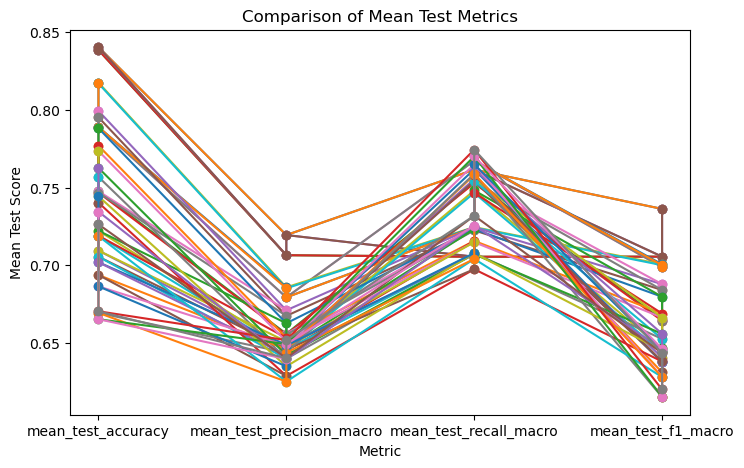

In [117]:
results_df = pd.DataFrame(grid_search.cv_results_)

# Let's pick the mean_test_* columns we want to compare
metrics = [
    "mean_test_accuracy",
    "mean_test_precision_macro",
    "mean_test_recall_macro",
    "mean_test_f1_macro"
]

#############################################
# (Optional) Filter to top models
#############################################
# For instance, select the 5 best models according to F1_macro
top_n = 5
results_top = results_df.nsmallest(top_n, "rank_test_f1_macro")

#############################################
# Melt the DataFrame to "long" format:
#############################################
# Identify any parameter columns you want in your plot label.
# E.g., 'param_n_neighbors', 'param_metric', 'param_p', 'param_weights', etc.
param_cols = ["param_knn__n_neighbors", "param_knn__metric", "param_knn__weights"]
plot_df = results_df.melt(
    id_vars=param_cols,      # keep these columns "as is"
    value_vars=metrics,      # the columns we want to "unpivot"
    var_name="metric",       # new column with the metric name
    value_name="score"       # new column with the metric value
)

#############################################
# Plot each param setting (model) as its own line
#############################################
plt.figure(figsize=(8, 5))

# groupby the parameter combination so each unique combo is one line
for combo, group in plot_df.groupby(param_cols):
    # Create a label describing these parameters
    # e.g., combo = (3, "minkowski", "uniform")
    # Make a nice string:
    label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
    
    # Plot the metric vs. score
    # 'metric' will be the x-axis (categorical) and 'score' will be y-axis
    plt.plot(group["metric"], group["score"], marker='o', label=label_str)

plt.xlabel("Metric")
plt.ylabel("Mean Test Score")
plt.title(f"Comparison of Mean Test Metrics")
#plt.legend()
plt.show()

In [118]:
joblib.dump(grid_search.best_estimator_, 'models/knn.pkl')

['models/knn.pkl']